# Principal Component Analysis and Clustering

- COMPSS 224B: Text Analysis for Political Risk
- Authors: Iris Malone and Mark Rosenberg
- Last Revised: 17 April 2025

## 1. See ISLP Chp 12 Lab

## 2. Real-World Example: CIRI Repression Data 



The CIRI Human Rights Dataset was a quantitative series measuring government respect for 15 internationally recognized human rights for 202 countries, annually from 1981-2011. It was designed to test theories about the causes and consequences of human rights violations, as well as policymakers and analysts who seek to estimate the human rights effects of a wide variety of institutional changes and public policies including democratization, economic aid, military aid, structural adjustment, and humanitarian intervention. See \url{https://dataverse.harvard.edu/dataverse/cirihumanrightsdata}

The CIRI dataset aims to measure human rights quality across countries. It aggregates many different characteristics to create a composite score PHYSINT. This is an 8-point sclae where 0 is `not free' and 8 is `free'. 

Scholars have previously criticized the aggregation schema as too opaque. 
- How are weights constructed?
- How much human bias is in the assessments?
- What explains a score of '1' vs' '2'? 
- Why do scores change?

Let's investigate to see how ML methods can provide a more data-driven assessment and alternative index.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
dfciri = pd.read_csv("cirirepression.csv")

# Filter data for the year 2011
dfciri = dfciri[dfciri['year'] == 2011] 
dfciri.index = dfciri['CTRY'].astype(str)
dfciri

,CTRY,year,CIRI,ccode,POLITY,UNCTRY,UNREG,UNSUBREG,PHYSINT,DISAP,...,OLD_MOVE,SPEECH,ELECSD,OLD_RELFRE,NEW_RELFRE,WORKER,WECON,WOPOL,WOSOC,INJUD
CTRY,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Afghanistan,2011,101,700.0,700.0,4.0,142,62,4.0,2.0,...,NaN,1.0,1.0,NaN,0.0,1.0,0.0,2.0,NaN,0.0
Albania,Albania,2011,104,339.0,339.0,8.0,150,39,6.0,2.0,...,NaN,1.0,1.0,NaN,1.0,1.0,1.0,2.0,NaN,0.0
Algeria,Algeria,2011,107,615.0,615.0,12.0,2,15,4.0,1.0,...,NaN,0.0,1.0,NaN,0.0,0.0,1.0,2.0,NaN,1.0
Andorra,Andorra,2011,110,232.0,232.0,20.0,150,39,8.0,2.0,...,NaN,2.0,2.0,NaN,2.0,0.0,3.0,3.0,NaN,2.0
Angola,Angola,2011,113,540.0,540.0,17.0,2,17,4.0,1.0,...,NaN,1.0,1.0,NaN,1.0,0.0,1.0,3.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Yemen, South","Yemen, South",2011,686,680.0,680.0,NaN,142,145,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yugoslavia,Yugoslavia,2011,689,345.0,345.0,891.0,150,39,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Yugoslavia, Federal Republic of","Yugoslavia, Federal Republic of",2011,692,345.0,347.0,891.0,150,39,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check out the different columns in the dataset:

In [10]:
dfciri.describe()

,year,CIRI,ccode,POLITY,UNCTRY,UNREG,UNSUBREG,PHYSINT,DISAP,KILL,...,OLD_MOVE,SPEECH,ELECSD,OLD_RELFRE,NEW_RELFRE,WORKER,WECON,WOPOL,WOSOC,INJUD
count,202.0,202.000000,199.000000,201.000000,198.000000,202.000000,202.000000,194.000000,195.000000,195.000000,...,0.0,195.000000,195.000000,0.0,195.000000,195.000000,195.000000,195.000000,0.0,195.000000
mean,2011.0,402.470297,469.994975,468.293532,441.343434,141.351485,58.277228,4.819588,1.235897,0.866667,...,NaN,0.517949,0.794872,NaN,0.866667,0.328205,0.917949,1.646154,NaN,0.538462
std,0.0,175.318734,261.787243,260.552736,259.965428,138.765632,55.076721,2.407550,5.671028,5.653451,...,NaN,5.617850,5.651291,NaN,5.668930,5.595928,5.681716,5.684390,NaN,5.646120
min,2011.0,101.000000,2.000000,2.000000,4.000000,2.000000,5.000000,0.000000,-77.000000,-77.000000,...,NaN,-77.000000,-77.000000,NaN,-77.000000,-77.000000,-77.000000,-77.000000,NaN,-77.000000
25%,2011.0,251.750000,307.500000,310.000000,212.500000,2.000000,14.000000,3.000000,1.000000,1.000000,...,NaN,0.000000,1.000000,NaN,0.000000,0.000000,1.000000,2.000000,NaN,0.000000
50%,2011.0,402.500000,451.000000,450.000000,436.000000,142.000000,35.000000,5.000000,2.000000,1.000000,...,NaN,1.000000,1.000000,NaN,2.000000,1.000000,1.000000,2.000000,NaN,1.000000
75%,2011.0,553.250000,679.500000,679.000000,673.000000,150.000000,62.000000,7.000000,2.000000,2.000000,...,NaN,1.000000,2.000000,NaN,2.000000,1.000000,2.000000,2.000000,NaN,2.000000
max,2011.0,700.000000,990.000000,990.000000,894.000000,419.000000,155.000000,8.000000,2.000000,2.000000,...,NaN,2.000000,2.000000,NaN,2.000000,2.000000,3.000000,3.000000,NaN,2.000000


Select relevant columns for analysis. We will focus analysis on the main inputs:
- [PHYSINT] Physical Integrity Rights Index

This is an additive index constructed from the Torture, Extrajudicial Killing, Political Imprisonment, and Disappearance indicators. It ranges from 0 (no government respect for these four rights) to 8 (full government respect for these four rights). Details on its construction and use can be found in: David L. Cingranelli and David L. Richards. 1999. "Measuring the Level, Pattern, and Sequence of Government Respect for Physical Integrity Rights." International Studies Quarterly, Vol 43.2: 407-18.
- [DISAP] Disappearance

Disappearances are cases in which people have disappeared, political motivation appears likely, and the victims have not been found. Knowledge of the whereabouts of the disappeared is, by definition, not public knowledge. However, while there is typically no way of knowing where victims are, it is typically known by whom they were taken and under what circumstances. A score of 0 indicates that disappearances have occurred frequently in a given year; a score of 1 indicates that disappearances occasionally occurred; and a score of 2 indicates that disappearances did not occur in a given year.
- [KILL] Extrajudicial Killing

Extrajudicial killings are killings by government officials without due process of law. They include murders by private groups if instigated by government. These killings may result from the deliberate, illegal, and excessive use of lethal force by the police, security forces, or other agents of the state whether against criminal suspects, detainees, prisoners, or others. A score of 0 indicates that extrajudicial killings were practiced frequently in a given year; a score of 1 indicates that extrajudicial killings were practiced occasionally; and a score of 2 indicates that such killings did not occur in a given year.
- [POLPRIS] Political Imprisonment

Political imprisonment refers to the incarceration of people by government officials because of: their speech; their non-violent opposition to government policies or leaders; their religious beliefs; their non-violent religious practices including proselytizing; or their membership in a group, including an ethnic or racial group. A score of 0 indicates that there were many people imprisoned because of their religious, political, or other beliefs in a given year; a score of 1 indicates that a few people were imprisoned; and a score of 2 indicates that no persons were imprisoned for any of the above reasons in a given year.
- [TORT] Torture

Torture refers to the purposeful inflicting of extreme pain, whether mental or physical, by government officials or by private individuals at the instigation of government officials. Torture includes the use of physical and other force by police and prison guards that is cruel, inhuman, or degrading. This also includes deaths in custody due to negligence by government officials. A score of 0 indicates that torture was practiced frequently in a given year; a score of 1 indicates that torture was practiced occasionally; and a score of 2 indicates that torture did not occur in a given year.
- [NEW_EMPINX] Empowerment Rights Index

This is an additive index constructed from the Foreign Movement, Domestic Movement, Freedom of Speech, Freedom of Assembly & Association, Workers’ Rights, Electoral Self- Determination, and Freedom of Religion indicators. It ranges from 0 (no government respect for these seven rights) to 14 (full government respect for these seven rights).
- [ASSN] Freedom of Assembly and Association

It is an internationally recognized right of citizens to assemble freely and to associate with other persons in political parties, trade unions, cultural organizations, or other special-interest groups. This variable indicates the extent to which the freedoms of assembly and association are subject to actual governmental limitations or restrictions (as opposed to strictly legal protections). A score of 0 indicates that citizens’ rights to freedom of assembly or association were severely restricted or denied completely to all citizens; a score of 1 indicates that these rights were limited for all citizens or severely restricted or denied for select groups; and a score of 2 indicates that these rights were virtually unrestricted and freely enjoyed by practically all citizens in a given year.
- [FORMOV] Freedom of Foreign Movement

This variable indicates citizens’ freedom to leave and return to their country. A score of 0 indicates that this freedom was severely restricted, a score of 1 indicates the freedom was somewhat restricted, and a score of 2 indicates unrestricted freedom of foreign movement. 
- [DOMMOV] Freedom of Domestic Movement

This variable indicates citizens’ freedom to travel within their own country. A score of 0 indicates that this freedom was severely restricted, a score of 1 indicates the freedom was somewhat restricted, and a score of 2 indicates unrestricted freedom of foreign movement. 

- [NEW_RELFRE] Freedom of Religion
This variable indicates the extent to which the freedom of citizens to exercise and practice their religious beliefs is subject to actual government restrictions. Citizens should be able to freely practice their religion and proselytize (attempt to convert) other citizens to their religion as long as such attempts are done in a non-coercive, peaceful manner. A score of 0 indicates that government restrictions on religious practices are severe and widespread. A score of 1 indicates such practices are moderate, and a 0 indicates such practices are practically absent. 


In [107]:
rel_ciri = dfciri.drop(columns=['CTRY', 'year', 'CIRI', 'ccode', 'POLITY', 'UNCTRY', 'UNREG', 'UNSUBREG',
                           'OLD_EMPINX', 'OLD_MOVE', 'OLD_RELFRE', 'WOSOC', 'PHYSINT'])
rel_ciri.describe()

DISAP        KILL     POLPRIS        TORT  NEW_EMPINX        ASSN  \
count  195.000000  195.000000  195.000000  195.000000  194.000000  195.000000   
mean     1.235897    0.866667    0.825641    0.287179    8.283505    0.733333   
std      5.671028    5.653451    5.662352    5.613826    3.936943    5.656915   
min    -77.000000  -77.000000  -77.000000  -77.000000    0.000000  -77.000000   
25%      1.000000    1.000000    0.000000    0.000000    5.000000    0.000000   
50%      2.000000    1.000000    1.000000    1.000000    9.000000    1.000000   
75%      2.000000    2.000000    2.000000    1.000000   12.000000    2.000000   
max      2.000000    2.000000    2.000000    2.000000   14.000000    2.000000   

           FORMOV      DOMMOV      SPEECH      ELECSD  NEW_RELFRE      WORKER  \
count  195.000000  195.000000  195.000000  195.000000  195.000000  195.000000   
mean     1.128205    1.107692    0.517949    0.794872    0.866667    0.328205   
std      5.671322    5.666295    5.617850    5.651291    5.668930    5.595928   
min    -77.000000  -77.000000  -77.000000  -77.000000  -77.000000  -77.000000   
25%      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
50%      2.000000    2.000000    1.000000    1.000000    2.000000    1.000000   
75%      2.000000    2.000000    1.000000    2.000000    2.000000    1.000000   
max      2.000000    2.000000    2.000000    2.000000    2.000000    2.000000   

            WECON       WOPOL       INJUD  
count  195.000000  195.000000  195.000000  
mean     0.917949    1.646154    0.538462  
std      5.681716    5.684390    5.646120  
min    -77.000000  -77.000000  -77.000000  
25%      1.000000    2.000000    0.000000  
50%      1.000000    2.000000    1.000000  
75%      2.000000    2.000000    2.000000  
max      3.000000    3.000000    2.000000

### 1. Inspect Missing Data

Count missing data:

In [74]:
print("\nNumber of missing values per column:")
print(rel_ciri.isnull().sum())



Number of missing values per column:
DISAP         7
KILL          7
POLPRIS       7
TORT          7
NEW_EMPINX    8
ASSN          7
FORMOV        7
DOMMOV        7
SPEECH        7
ELECSD        7
NEW_RELFRE    7
WORKER        7
WECON         7
WOPOL         7
INJUD         7
dtype: int64


#### Missing data functions
- iTables provides a nice interactive format to look at data
- Different functions help isolate types of missingness (time series or cross-sectional)


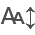

In [ ]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
from itables import show

def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
  
    return mis_val_table_ren_columns

# I also often use time series cross-sectional specific functions 
# to use in your own work modify by unit and date vars
def missing_country_table(df):
    df.reset_index(inplace=True)
    #df.drop(columns=['index', 'level_0'])
    mis_val = df.groupby(['CTRY']).apply(lambda x: x.isna().sum())
    mis_val_table = pd.concat([mis_val], axis=1)    
    return mis_val_table


In [91]:
missing_values_table(rel_ciri)


Your selected dataframe has 15 columns.
There are 15 columns that have missing values.


Missing Values  % of Total Values
NEW_EMPINX               8                4.0
DISAP                    7                3.5
KILL                     7                3.5
POLPRIS                  7                3.5
TORT                     7                3.5
ASSN                     7                3.5
FORMOV                   7                3.5
DOMMOV                   7                3.5
SPEECH                   7                3.5
ELECSD                   7                3.5
NEW_RELFRE               7                3.5
WORKER                   7                3.5
WECON                    7                3.5
WOPOL                    7                3.5
INJUD                    7                3.5

In [94]:
missing_country_table(rel_ciri)

/var/folders/0m/d48fpfjn78d7h8p68fydssdm0000gn/T/ipykernel_42267/2312158390.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mis_val = df.groupby(['CTRY']).apply(lambda x: x.isna().sum())


index  CTRY  DISAP  KILL  POLPRIS  TORT  \
CTRY                                                                       
Afghanistan                          0     0      0     0        0     0   
Albania                              0     0      0     0        0     0   
Algeria                              0     0      0     0        0     0   
Andorra                              0     0      0     0        0     0   
Angola                               0     0      0     0        0     0   
...                                ...   ...    ...   ...      ...   ...   
Yemen, South                         0     0      1     1        1     1   
Yugoslavia                           0     0      1     1        1     1   
Yugoslavia, Federal Republic of      0     0      1     1        1     1   
Zambia                               0     0      0     0        0     0   
Zimbabwe                             0     0      0     0        0     0   

                                 NEW_EMPINX  ASSN  FORMOV  DOMMOV  SPEECH  \
CTRY                                                                        
Afghanistan                               0     0       0       0       0   
Albania                                   0     0       0       0       0   
Algeria                                   0     0       0       0       0   
Andorra                                   0     0       0       0       0   
Angola                                    0     0       0       0       0   
...                                     ...   ...     ...     ...     ...   
Yemen, South                              1     1       1       1       1   
Yugoslavia                                1     1       1       1       1   
Yugoslavia, Federal Republic of           1     1       1       1       1   
Zambia                                    0     0       0       0       0   
Zimbabwe                                  0     0       0       0       0   

                                 ELECSD  NEW_RELFRE  WORKER  WECON  WOPOL  \
CTRY                                                                        
Afghanistan                           0           0       0      0      0   
Albania                               0           0       0      0      0   
Algeria                               0           0       0      0      0   
Andorra                               0           0       0      0      0   
Angola                                0           0       0      0      0   
...                                 ...         ...     ...    ...    ...   
Yemen, South                          1           1       1      1      1   
Yugoslavia                            1           1       1      1      1   
Yugoslavia, Federal Republic of       1           1       1      1      1   
Zambia                                0           0       0      0      0   
Zimbabwe                              0           0       0      0      0   

                                 INJUD  
CTRY                                    
Afghanistan                          0  
Albania                              0  
Algeria                              0  
Andorra                              0  
Angola                               0  
...                                ...  
Yemen, South                         1  
Yugoslavia                           1  
Yugoslavia, Federal Republic of      1  
Zambia                               0  
Zimbabwe                             0  

[202 rows x 17 columns]

* Commentary *: My polisci reading is that data is missing for 2011 because these countries no longer exist.

We can alternatively visually inspect missingness using missingno

<Axes: >

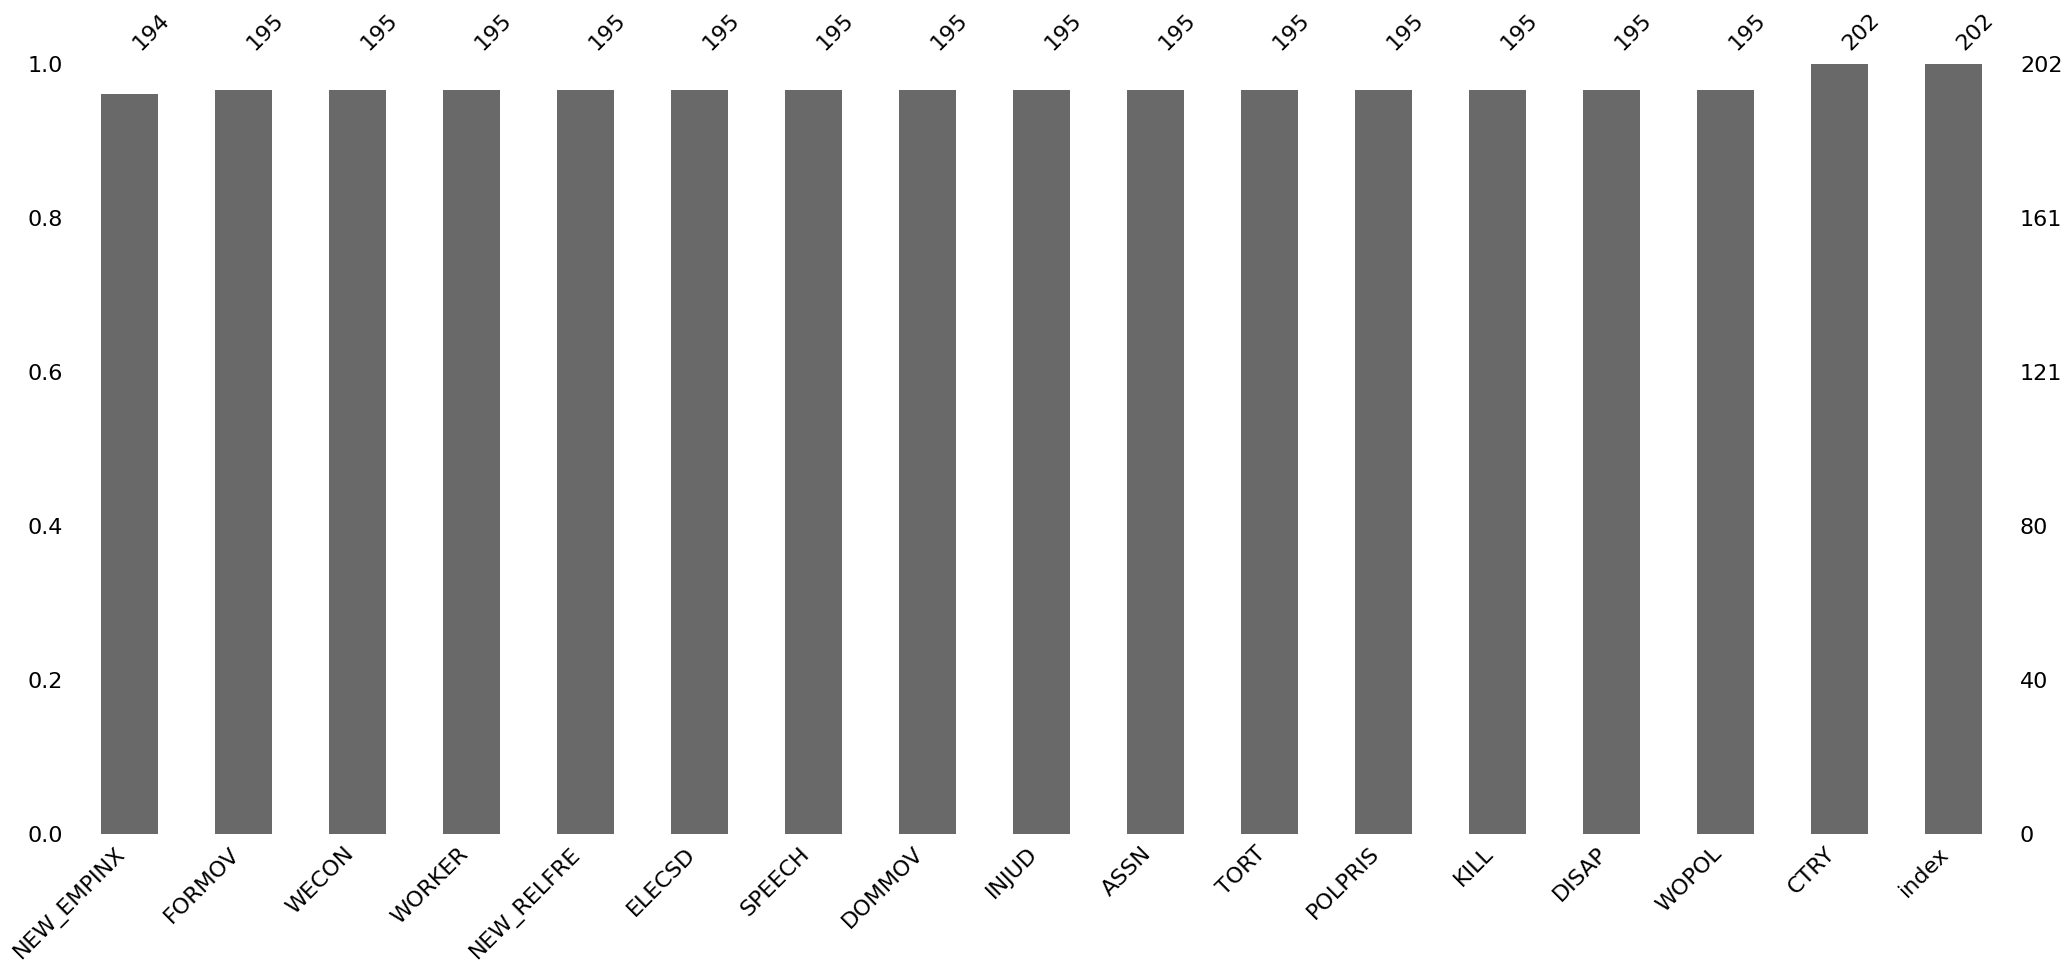

In [97]:
import missingno as msno

#barplot tells us number of columns with complete information
msno.bar(rel_ciri, sort="ascending")


<Axes: >

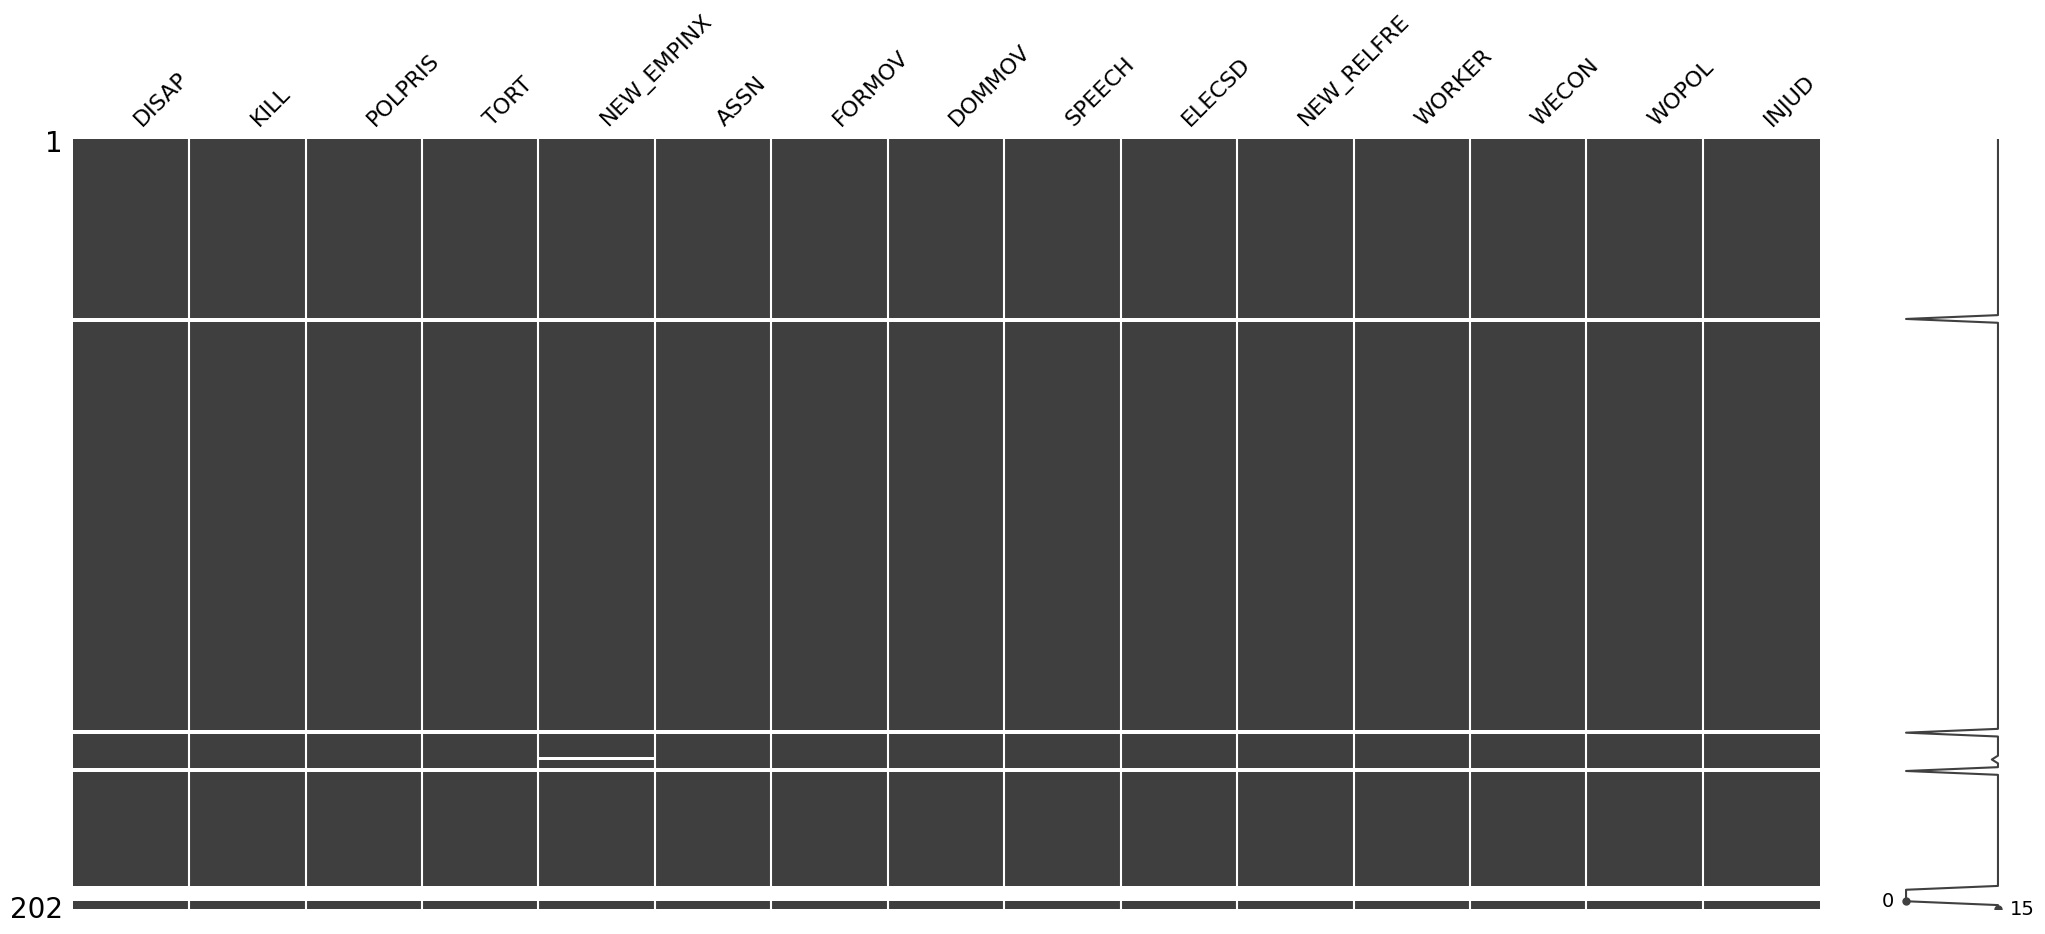

In [34]:
#matrix tells us where data is missing
#right axis shows us where in the index data is missing -- so some early country, and then a lot of countries at the end
msno.matrix(rel_ciri)

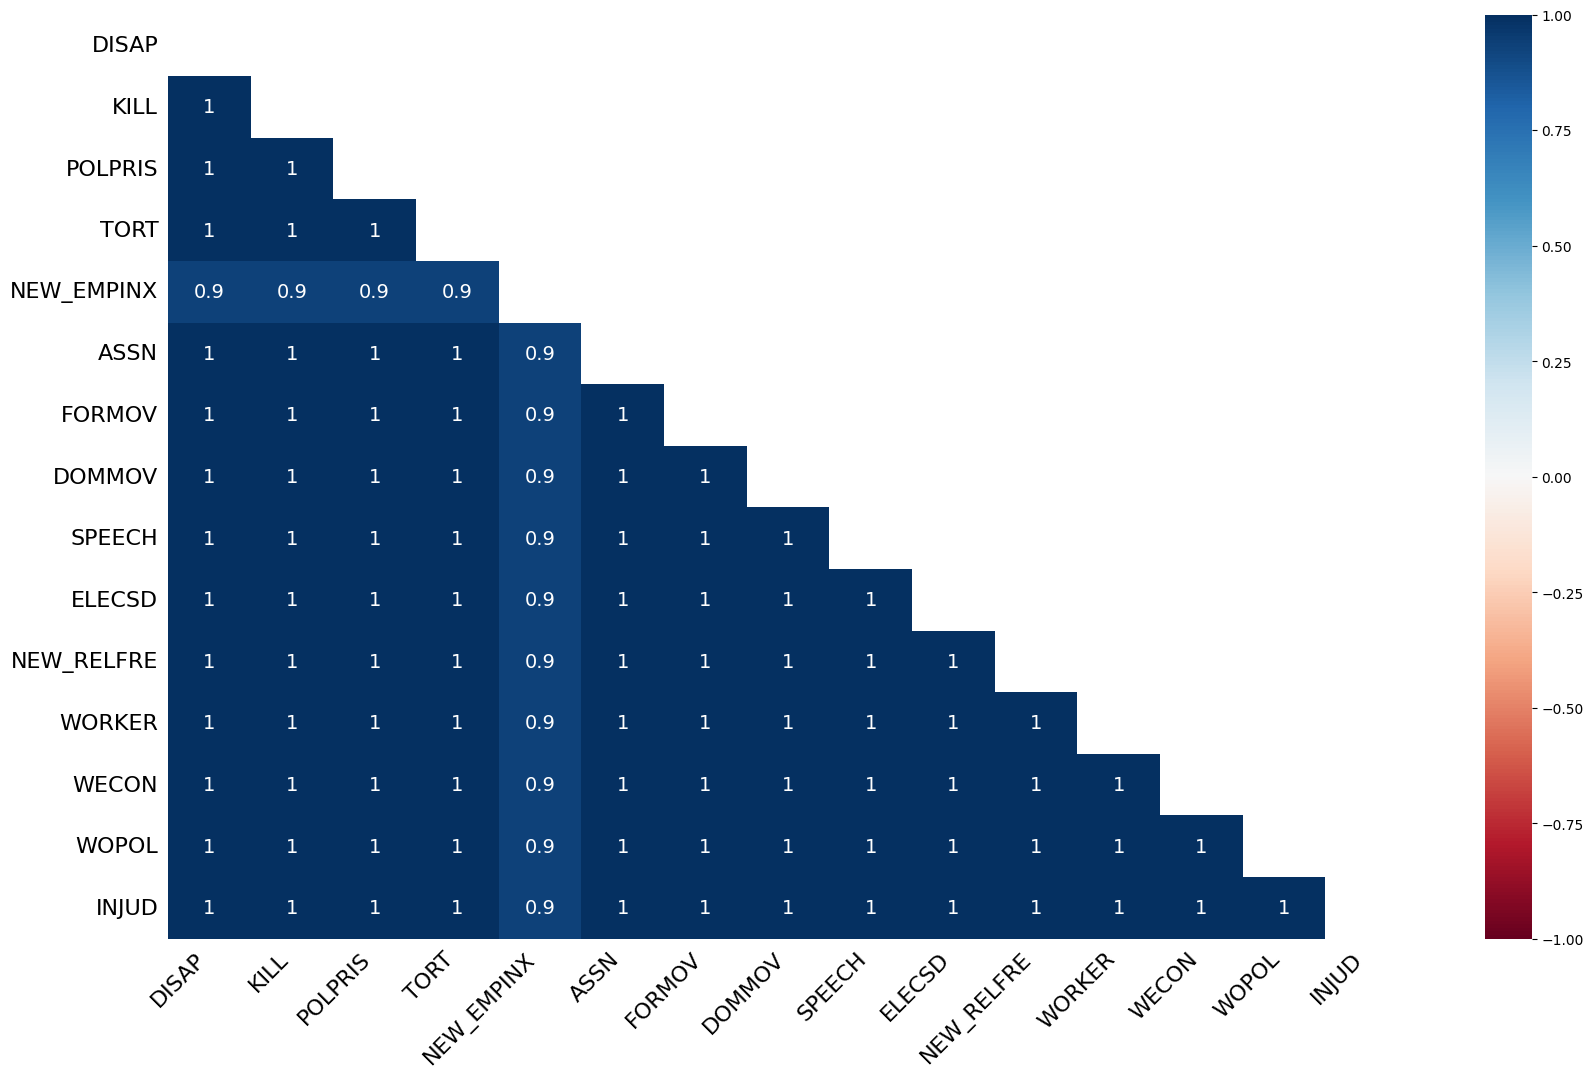

In [28]:
#heatmap tells us how correlated the missingness is (this can be useful for assessing if it's conditional at random)
msno.heatmap(rel_ciri)
plt.show()


*Commentary* Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does). The above suggests there is no systematic missingness

## 2. Handling Missing Data

### A. If MCAR:

In [ ]:
#drop completely
drop_ciri = rel_ciri.dropna()


### B. If Missing at Random:

In [123]:
#imputation libraries
from sklearn.impute import SimpleImputer, KNNImputer


- Mean Imputation

In [116]:
#preset libraries
from sklearn.impute import SimpleImputer, KNNImputer

rel_ciri = dfciri.drop(columns=['CTRY', 'year', 'CIRI', 'ccode', 'POLITY', 'UNCTRY', 'UNREG', 'UNSUBREG',
                           'OLD_EMPINX', 'OLD_MOVE', 'OLD_RELFRE', 'WOSOC', 'PHYSINT'])
#if working through notebook from above you'll need to reset the index
#rel_ciri = rel_ciri.set_index(['CTRY'])
mean_imputer = SimpleImputer(strategy='mean')
mean_imp_array = mean_imputer.fit_transform(rel_ciri)
mean_imp_ciri = pd.DataFrame(mean_imp_array, columns=rel_ciri.columns, index=rel_ciri.index)

In [ ]:
#Check
mean_imp_ciri

DISAP      KILL   POLPRIS      TORT  \
CTRY                                                                      
Afghanistan                      2.000000  0.000000  2.000000  0.000000   
Albania                          2.000000  1.000000  2.000000  1.000000   
Algeria                          1.000000  1.000000  1.000000  1.000000   
Andorra                          2.000000  2.000000  2.000000  2.000000   
Angola                           1.000000  1.000000  1.000000  1.000000   
...                                   ...       ...       ...       ...   
Yemen, South                     1.235897  0.866667  0.825641  0.287179   
Yugoslavia                       1.235897  0.866667  0.825641  0.287179   
Yugoslavia, Federal Republic of  1.235897  0.866667  0.825641  0.287179   
Zambia                           2.000000  1.000000  1.000000  0.000000   
Zimbabwe                         1.000000  1.000000  0.000000  0.000000   

                                 NEW_EMPINX      ASSN    FORMOV    DOMMOV  \
CTRY                                                                        
Afghanistan                        4.000000  1.000000  0.000000  0.000000   
Albania                            9.000000  2.000000  1.000000  2.000000   
Algeria                            3.000000  0.000000  1.000000  1.000000   
Andorra                           12.000000  2.000000  2.000000  2.000000   
Angola                             4.000000  0.000000  0.000000  1.000000   
...                                     ...       ...       ...       ...   
Yemen, South                       8.283505  0.733333  1.128205  1.107692   
Yugoslavia                         8.283505  0.733333  1.128205  1.107692   
Yugoslavia, Federal Republic of    8.283505  0.733333  1.128205  1.107692   
Zambia                             8.000000  1.000000  1.000000  2.000000   
Zimbabwe                           0.000000  0.000000  0.000000  0.000000   

                                   SPEECH    ELECSD  NEW_RELFRE    WORKER  \
CTRY                                                                        
Afghanistan                      1.000000  1.000000    0.000000  1.000000   
Albania                          1.000000  1.000000    1.000000  1.000000   
Algeria                          0.000000  1.000000    0.000000  0.000000   
Andorra                          2.000000  2.000000    2.000000  0.000000   
Angola                           1.000000  1.000000    1.000000  0.000000   
...                                   ...       ...         ...       ...   
Yemen, South                     0.517949  0.794872    0.866667  0.328205   
Yugoslavia                       0.517949  0.794872    0.866667  0.328205   
Yugoslavia, Federal Republic of  0.517949  0.794872    0.866667  0.328205   
Zambia                           1.000000  1.000000    1.000000  1.000000   
Zimbabwe                         0.000000  0.000000    0.000000  0.000000   

                                    WECON     WOPOL     INJUD  
CTRY                                                           
Afghanistan                      0.000000  2.000000  0.000000  
Albania                          1.000000  2.000000  0.000000  
Algeria                          1.000000  2.000000  1.000000  
Andorra                          3.000000  3.000000  2.000000  
Angola                           1.000000  3.000000  0.000000  
...                                   ...       ...       ...  
Yemen, South                     0.917949  1.646154  0.538462  
Yugoslavia                       0.917949  1.646154  0.538462  
Yugoslavia, Federal Republic of  0.917949  1.646154  0.538462  
Zambia                           0.000000  2.000000  1.000000  
Zimbabwe                         1.000000  2.000000  0.000000  

[202 rows x 15 columns]

- Median Imputation

In [ ]:
#preset librari
median_imputer = SimpleImputer(strategy='median')
median_imp_array = mean_imputer.fit_transform(rel_ciri)
median_imp_ciri = pd.DataFrame(median_imp_array, columns=rel_ciri.columns, index=rel_ciri.index)


In [120]:
median_imp_ciri

DISAP      KILL   POLPRIS      TORT  \
CTRY                                                                      
Afghanistan                      2.000000  0.000000  2.000000  0.000000   
Albania                          2.000000  1.000000  2.000000  1.000000   
Algeria                          1.000000  1.000000  1.000000  1.000000   
Andorra                          2.000000  2.000000  2.000000  2.000000   
Angola                           1.000000  1.000000  1.000000  1.000000   
...                                   ...       ...       ...       ...   
Yemen, South                     1.235897  0.866667  0.825641  0.287179   
Yugoslavia                       1.235897  0.866667  0.825641  0.287179   
Yugoslavia, Federal Republic of  1.235897  0.866667  0.825641  0.287179   
Zambia                           2.000000  1.000000  1.000000  0.000000   
Zimbabwe                         1.000000  1.000000  0.000000  0.000000   

                                 NEW_EMPINX      ASSN    FORMOV    DOMMOV  \
CTRY                                                                        
Afghanistan                        4.000000  1.000000  0.000000  0.000000   
Albania                            9.000000  2.000000  1.000000  2.000000   
Algeria                            3.000000  0.000000  1.000000  1.000000   
Andorra                           12.000000  2.000000  2.000000  2.000000   
Angola                             4.000000  0.000000  0.000000  1.000000   
...                                     ...       ...       ...       ...   
Yemen, South                       8.283505  0.733333  1.128205  1.107692   
Yugoslavia                         8.283505  0.733333  1.128205  1.107692   
Yugoslavia, Federal Republic of    8.283505  0.733333  1.128205  1.107692   
Zambia                             8.000000  1.000000  1.000000  2.000000   
Zimbabwe                           0.000000  0.000000  0.000000  0.000000   

                                   SPEECH    ELECSD  NEW_RELFRE    WORKER  \
CTRY                                                                        
Afghanistan                      1.000000  1.000000    0.000000  1.000000   
Albania                          1.000000  1.000000    1.000000  1.000000   
Algeria                          0.000000  1.000000    0.000000  0.000000   
Andorra                          2.000000  2.000000    2.000000  0.000000   
Angola                           1.000000  1.000000    1.000000  0.000000   
...                                   ...       ...         ...       ...   
Yemen, South                     0.517949  0.794872    0.866667  0.328205   
Yugoslavia                       0.517949  0.794872    0.866667  0.328205   
Yugoslavia, Federal Republic of  0.517949  0.794872    0.866667  0.328205   
Zambia                           1.000000  1.000000    1.000000  1.000000   
Zimbabwe                         0.000000  0.000000    0.000000  0.000000   

                                    WECON     WOPOL     INJUD  
CTRY                                                           
Afghanistan                      0.000000  2.000000  0.000000  
Albania                          1.000000  2.000000  0.000000  
Algeria                          1.000000  2.000000  1.000000  
Andorra                          3.000000  3.000000  2.000000  
Angola                           1.000000  3.000000  0.000000  
...                                   ...       ...       ...  
Yemen, South                     0.917949  1.646154  0.538462  
Yugoslavia                       0.917949  1.646154  0.538462  
Yugoslavia, Federal Republic of  0.917949  1.646154  0.538462  
Zambia                           0.000000  2.000000  1.000000  
Zimbabwe                         1.000000  2.000000  0.000000  

[202 rows x 15 columns]

Suppose you only need to modify one column:

In [122]:
column_to_impute = 'DISAP'

# Create a copy of the DataFrame
rel_ciri_imputed = rel_ciri.copy()

# Initialize and fit the imputer on the specific column and impute
median_imputer = SimpleImputer(strategy='median')
rel_ciri_imputed[column_to_impute] = median_imputer.fit_transform(rel_ciri_imputed[[column_to_impute]])

print("Original DataFrame:")
print(rel_ciri['DISAP'])
print("\nDataFrame with Imputed Values (already merged):")
print(rel_ciri_imputed['DISAP'])

Original DataFrame:
CTRY
Afghanistan                        2.0
Albania                            2.0
Algeria                            1.0
Andorra                            2.0
Angola                             1.0
                                  ... 
Yemen, South                       NaN
Yugoslavia                         NaN
Yugoslavia, Federal Republic of    NaN
Zambia                             2.0
Zimbabwe                           1.0
Name: DISAP, Length: 202, dtype: float64

DataFrame with Imputed Values (already merged):
CTRY
Afghanistan                        2.0
Albania                            2.0
Algeria                            1.0
Andorra                            2.0
Angola                             1.0
                                  ... 
Yemen, South                       2.0
Yugoslavia                         2.0
Yugoslavia, Federal Republic of    2.0
Zambia                             2.0
Zimbabwe                           1.0
Name: DISAP, Length: 2

- KNN Imputation

In [125]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pipeline_knn = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5))
])

knn_ciri = pd.DataFrame(pipeline_knn.fit_transform(rel_ciri), columns=rel_ciri.columns)
knn_ciri


DISAP      KILL   POLPRIS      TORT  NEW_EMPINX      ASSN    FORMOV  \
0    2.000000  0.000000  2.000000  0.000000    4.000000  1.000000  0.000000   
1    2.000000  1.000000  2.000000  1.000000    9.000000  2.000000  1.000000   
2    1.000000  1.000000  1.000000  1.000000    3.000000  0.000000  1.000000   
3    2.000000  2.000000  2.000000  2.000000   12.000000  2.000000  2.000000   
4    1.000000  1.000000  1.000000  1.000000    4.000000  0.000000  0.000000   
..        ...       ...       ...       ...         ...       ...       ...   
197  1.235897  0.866667  0.825641  0.287179    8.283505  0.733333  1.128205   
198  1.235897  0.866667  0.825641  0.287179    8.283505  0.733333  1.128205   
199  1.235897  0.866667  0.825641  0.287179    8.283505  0.733333  1.128205   
200  2.000000  1.000000  1.000000  0.000000    8.000000  1.000000  1.000000   
201  1.000000  1.000000  0.000000  0.000000    0.000000  0.000000  0.000000   

       DOMMOV    SPEECH    ELECSD  NEW_RELFRE    WORKER     WECON     WOPOL  \
0    0.000000  1.000000  1.000000    0.000000  1.000000  0.000000  2.000000   
1    2.000000  1.000000  1.000000    1.000000  1.000000  1.000000  2.000000   
2    1.000000  0.000000  1.000000    0.000000  0.000000  1.000000  2.000000   
3    2.000000  2.000000  2.000000    2.000000  0.000000  3.000000  3.000000   
4    1.000000  1.000000  1.000000    1.000000  0.000000  1.000000  3.000000   
..        ...       ...       ...         ...       ...       ...       ...   
197  1.107692  0.517949  0.794872    0.866667  0.328205  0.917949  1.646154   
198  1.107692  0.517949  0.794872    0.866667  0.328205  0.917949  1.646154   
199  1.107692  0.517949  0.794872    0.866667  0.328205  0.917949  1.646154   
200  2.000000  1.000000  1.000000    1.000000  1.000000  0.000000  2.000000   
201  0.000000  0.000000  0.000000    0.000000  0.000000  1.000000  2.000000   

        INJUD  
0    0.000000  
1    0.000000  
2    1.000000  
3    2.000000  
4    0.000000  
..        ...  
197  0.538462  
198  0.538462  
199  0.538462  
200  1.000000  
201  0.000000  

[202 rows x 15 columns]

In [128]:

# Use pipeline in sklearn to iteratively 
# Scale and then impute
pipeline_knn_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5))
])

#alternatively might scale the databefore
knn_ciri = pd.DataFrame(pipeline_knn_scaled.fit_transform(rel_ciri), columns=rel_ciri.columns)
knn_ciri

DISAP          KILL       POLPRIS          TORT    NEW_EMPINX  \
0    1.350847e-01 -1.536933e-01  2.079316e-01 -5.128743e-02 -1.090843e+00   
1    1.350847e-01  2.364512e-02  2.079316e-01  1.273027e-01  1.824636e-01   
2   -4.170401e-02  2.364512e-02  3.087194e-02  1.273027e-01 -1.345505e+00   
3    1.350847e-01  2.009835e-01  2.079316e-01  3.058929e-01  9.464477e-01   
4   -4.170401e-02  2.364512e-02  3.087194e-02  1.273027e-01 -1.090843e+00   
..            ...           ...           ...           ...           ...   
197 -3.188333e-17 -4.554761e-18  9.109522e-18  2.732857e-17 -1.922860e-16   
198 -3.188333e-17 -4.554761e-18  9.109522e-18  2.732857e-17 -1.922860e-16   
199 -3.188333e-17 -4.554761e-18  9.109522e-18  2.732857e-17 -1.922860e-16   
200  1.350847e-01  2.364512e-02  3.087194e-02 -5.128743e-02 -7.219782e-02   
201 -4.170401e-02  2.364512e-02 -1.461877e-01 -5.128743e-02 -2.109489e+00   

             ASSN        FORMOV        DOMMOV        SPEECH    ELECSD  \
0    4.726128e-02 -1.994437e-01 -1.959911e-01  8.602794e-02  0.036391   
1    2.244911e-01 -2.266405e-02  1.578817e-01  8.602794e-02  0.036391   
2   -1.299685e-01 -2.266405e-02 -1.905469e-02 -9.243427e-02  0.036391   
3    2.244911e-01  1.541155e-01  1.578817e-01  2.644901e-01  0.213797   
4   -1.299685e-01 -1.994437e-01 -1.905469e-02  8.602794e-02  0.036391   
..            ...           ...           ...           ...       ...   
197 -1.366428e-17 -2.277381e-17 -3.188333e-17  4.554761e-18  0.000000   
198 -1.366428e-17 -2.277381e-17 -3.188333e-17  4.554761e-18  0.000000   
199 -1.366428e-17 -2.277381e-17 -3.188333e-17  4.554761e-18  0.000000   
200  4.726128e-02 -2.266405e-02  1.578817e-01  8.602794e-02  0.036391   
201 -1.299685e-01 -1.994437e-01 -1.959911e-01 -9.243427e-02 -0.141015   

       NEW_RELFRE        WORKER         WECON     WOPOL         INJUD  
0   -1.532736e-01  1.203597e-01 -1.619778e-01  0.062409 -9.561390e-02  
1    2.358056e-02  1.203597e-01  1.447846e-02  0.062409 -9.561390e-02  
2   -1.532736e-01 -5.880168e-02  1.447846e-02  0.062409  8.195477e-02  
3    2.004347e-01 -5.880168e-02  3.673909e-01  0.238782  2.595235e-01  
4    2.358056e-02 -5.880168e-02  1.447846e-02  0.238782 -9.561390e-02  
..            ...           ...           ...       ...           ...  
197 -1.821904e-17  4.554761e-18  1.366428e-17  0.000000  5.010237e-17  
198 -1.821904e-17  4.554761e-18  1.366428e-17  0.000000  5.010237e-17  
199 -1.821904e-17  4.554761e-18  1.366428e-17  0.000000  5.010237e-17  
200  2.358056e-02  1.203597e-01 -1.619778e-01  0.062409  8.195477e-02  
201 -1.532736e-01 -5.880168e-02  1.447846e-02  0.062409 -9.561390e-02  

[202 rows x 15 columns]

### C. If Missing Not at Random:

**ABOVE ALL - TRY TO FIND BETTER DATA.**

The most common real world case where data is missing (not at random) is in time series data. There might be censored observations because the dataset isn't updated anymore. 

Under very strict assumptions, data analysts will 'plug in' gaps based DGP. (For example, the dataseries is relatively static but not updated one year.)

In [5]:
# Option 1: Forward Fill
fill_ciri['DISAP'] = fill_ciri.groupby('country')['DISAP'].ffill()

# Option 2: Back Fill
fill_ciri['DISAP'] = fill_ciri.groupby('country')['DISAP'].bfill()

# Option 3: Interpolate
fill_ciri['DISAP'] = fill_ciri.groupby('country')['DISAP'].interpolate(method='polynomial', order=2)


NameError: name 'fill_ciri' is not defined

## 2. Principal Component Analysis

### Run PCA

In [130]:
#method: going to drop Soviet Union, Yemen, etc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
drop_ciri = rel_ciri.dropna()

#scale
scaler = StandardScaler()
ciri_scaled = scaler.fit_transform(drop_ciri)

# Perform PCA
pca_ciri = PCA(n_components=None) # n_components=None to keep all components initially
ciri_out = pca_ciri.fit_transform(ciri_scaled)

# Loadings (eigenvectors)
loadings = pca_ciri.components_.T
loadings_df = pd.DataFrame(loadings, index=pr.columns)
print("\nLoadings (Eigenvectors):\n", loadings_df)



Loadings (Eigenvectors):
                   0         1         2         3         4         5   \
DISAP       0.232891  0.092413 -0.074180  0.635388 -0.288794  0.166084   
KILL        0.227074  0.513912 -0.000354  0.327144 -0.140388  0.099933   
POLPRIS     0.298062  0.075241 -0.150495  0.208192 -0.016219 -0.169374   
TORT        0.239421  0.433831  0.089397 -0.212854 -0.025491 -0.324528   
NEW_EMPINX  0.347975 -0.209725 -0.078152 -0.098647 -0.017996  0.022426   
ASSN        0.307470 -0.103876 -0.087290 -0.133582  0.076767 -0.096453   
FORMOV      0.222628 -0.005605 -0.045253 -0.478955 -0.549438  0.543182   
DOMMOV      0.290916 -0.224627  0.004225  0.004412 -0.188910  0.013638   
SPEECH      0.254781 -0.181810 -0.231508  0.055340  0.101219  0.083049   
ELECSD      0.290197 -0.173340  0.009623 -0.091594  0.082223 -0.223804   
NEW_RELFRE  0.262988 -0.242189 -0.112157  0.004543 -0.085874 -0.472905   
WORKER      0.227428 -0.204647  0.060877  0.176425  0.599587  0.482972   
WECON      

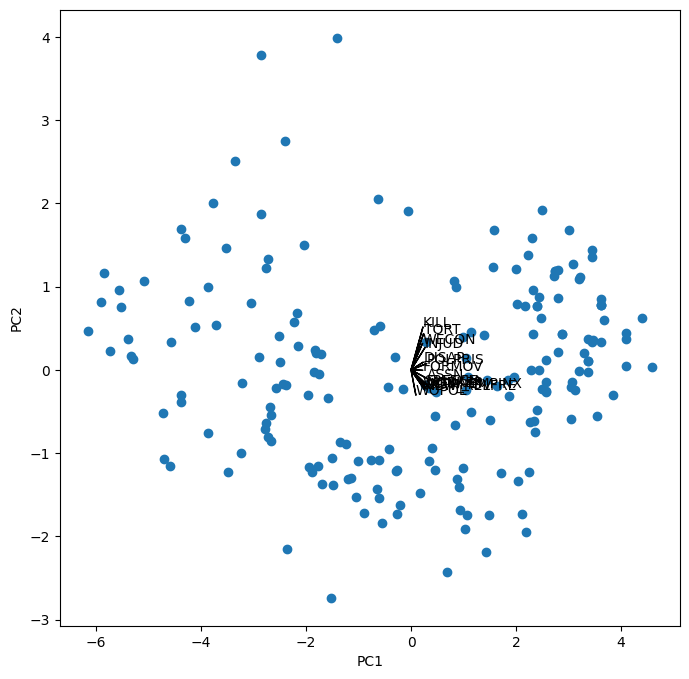

In [139]:
scores = pca_ciri.transform(ciri_scaled)
i, j = 0, 1 # which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:,0], scores[:,1])
ax.set_xlabel('PC%d' % (i+1))
ax.set_ylabel('PC%d' % (j+1))
for k in range(pca_ciri.components_.shape[1]):
    ax.arrow(0, 0, pca_ciri.components_[i,k], pca_ciri.components_[j,k])
    ax.text(pca_ciri.components_[i,k],
            pca_ciri.components_[j,k],
            drop_ciri.columns[k])



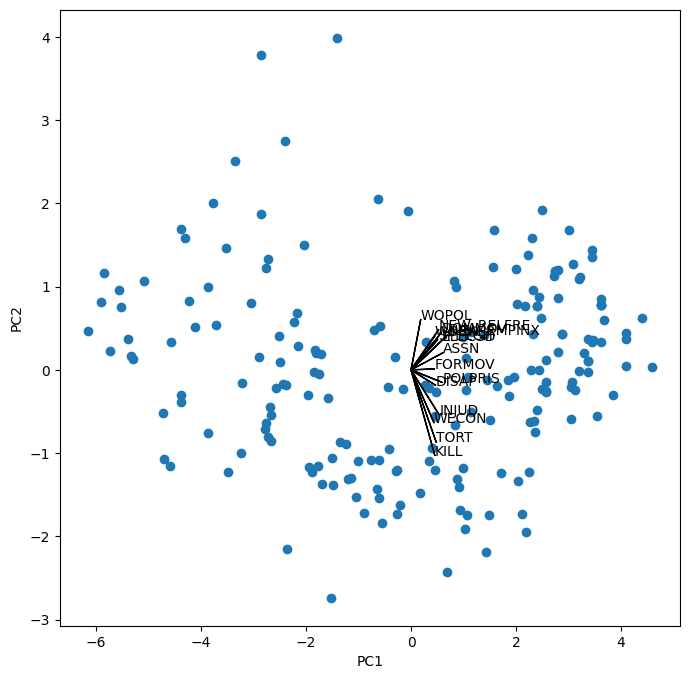

In [143]:
scale_arrow = s_ = 2
scores[:,1] *= -1
pca_ciri.components_[1] *= -1 # flip the y-axis
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:,0], scores[:,1])
ax.set_xlabel('PC%d' % (i+1))
ax.set_ylabel('PC%d' % (j+1))
for k in range(pca_ciri.components_.shape[1]):
    ax.arrow(0, 0, s_*pca_ciri.components_[i,k], s_*pca_ciri.components_[j,k])
    ax.text(s_*pca_ciri.components_[i,k],
            s_*pca_ciri.components_[j,k],
            drop_ciri.columns[k])


In [144]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def biplot(plt, pca, X, labels=None, colors=None,
           xpc=1, ypc=2, scale=1):
    """Generate biplot from a sklearn.decomposition.PCA object.

    Parameters
    ----------
    plt : object
        An existing pyplot module reference.

    pca : sklearn.decomposition.PCA
        A fitted PCA object from scikit-learn.

    X : array-like or pandas.DataFrame
        The original data matrix that was used to fit the PCA model.
        Required to get the column names for variable vectors.

    labels : array_like, optional
        Labels for each observation.

    colors : array_like, optional
        Colors for each observation.

    xpc, ypc : int, optional
        The principal component number for x- and y-axis. Defaults to
        (xpc, ypc) = (1, 2).

    scale : float
        The variables are scaled by sqrt(eigenvalue) ** scale, and the
        observations are scaled by sqrt(eigenvalue) ** (1 - scale).
        Must be in [0, 1].

    Returns
    -------
    None.

    """
    xpc, ypc = (xpc - 1, ypc - 1)
    n_components = pca.n_components_

    if xpc >= n_components or ypc >= n_components:
        raise ValueError(f"xpc and ypc must be less than the number of components ({n_components})")

    # Reduced data (scores)
    factors = pca.transform(X)
    xs = factors[:, xpc]
    ys = factors[:, ypc]

    # Eigenvalues
    evals = pca.explained_variance_
    singvals = np.sqrt(evals)

    if labels is not None:
        for i, (t, x, y) in enumerate(zip(labels, xs, ys)):
            c = 'k' if colors is None else colors[i]
            plt.text(x, y, t, color=c, ha='center', va='center')
        xmin, xmax = xs.min(), xs.max()
        ymin, ymax = ys.min(), ys.max()
        xpad = (xmax - xmin) * 0.1
        ypad = (ymax - ymin) * 0.1
        plt.xlim(xmin - xpad, xmax + xpad)
        plt.ylim(ymin - ypad, ymax + ypad)
    else:
        colors = 'k' if colors is None else colors
        plt.scatter(xs, ys, c=colors, marker='.')

    # Loadings (eigenvectors)
    evecs = pca.components_.T

    # Scale variable vectors
    tvars = evecs[:, [xpc, ypc]] * singvals[[xpc, ypc]]**scale

    if isinstance(X, pd.DataFrame):
        varnames = X.columns.values
    else:
        varnames = [f'Variable {i+1}' for i in range(X.shape[1])]

    for i, (x, y) in enumerate(tvars):
        plt.arrow(0, 0, x, y, color='r',
                  width=0.002, head_width=0.05)
        plt.text(x * 1.2, y * 1.2, varnames[i], color='r', ha='center', va='center')

    plt.xlabel(f'PC{xpc + 1} ({pca.explained_variance_ratio_[xpc]:.2%})')
    plt.ylabel(f'PC{ypc + 1} ({pca.explained_variance_ratio_[ypc]:.2%})')
    plt.axvline(0, color='k', linestyle='--', linewidth=0.5)
    plt.axhline(0, color='k', linestyle='--', linewidth=0.5)

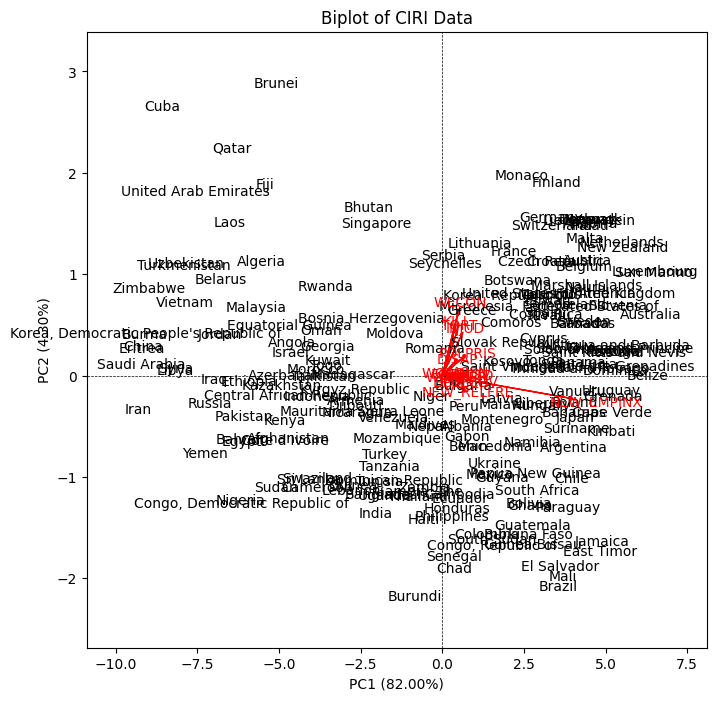

In [147]:
# Load a sample dataset
labels = drop_ciri.index

# Perform PCA
pca = PCA(n_components=2)
pca.fit(drop_ciri)

# Create the biplot
plt.figure(figsize=(8, 8))
biplot(plt, pca, drop_ciri, labels=labels
       )
plt.title('Biplot of CIRI Data')
plt.show()

### Create index

Few options - either normalize PC1 or take PVE times weight loaded index

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def pca_scores(risk_data):
    pca_risk_function = PCA() 
        #scale
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(risk_data)

    # Perform PCA
    #pca_risk_function.fit_transform(df_scaled)
    pca_risk_function.fit(df_scaled)
    #standard scaler creates z score (N(0, 1)) while minmax transforms ~U[0, 1]

    loadings = pd.DataFrame(pca_risk_function.components_.T, index = list(risk_data.columns))
    # Create a factor's names
    facs = ['PCA' + ' ' + str(i + 1) for i in range(pca_risk_function.components_.shape[1])]
    #estimate PCA loadings
    df_factors_scaled = pd.DataFrame(data = pca_risk_function.fit_transform(df_scaled),
                             index = risk_data.index,
                                 columns = facs)
    n_components = pca_risk_function.components_.shape[0]
    dict_index = {}
    #for each loading multiply by proportion explained variance to get weighted explanatory value
    #metho: https://medium.com/analytics-vidhya/the-factor-analysis-for-constructing-a-composite-index-2496686fc54c
    for i in range(n_components):
        key = df_factors_scaled.columns[i]
        value = df_factors_scaled.iloc[:,i].values * pca_risk_function.explained_variance_ratio_[i]
        dict_index.update({key:value})
    #for each princial component multiply explained variance by loading
    df_index = pd.DataFrame(dict_index,
                        index = risk_data.index)

    # Assign the composite index and ranking
    # alternatively just take df_index['PC_1'] and standardize from there
    df_index['PCA_Score'] = df_index.sum(axis = 1).values*100
    minmaxscaler = MinMaxScaler()
    df_index[['PCA_Score']] = minmaxscaler.fit_transform(df_index[['PCA_Score']])*100
    return pd.DataFrame(df_index)

In [160]:
pca_scores(drop_ciri)

PCA 1     PCA 2     PCA 3     PCA 4     PCA 5     PCA 6  \
CTRY                                                                      
Afghanistan -1.361447 -0.069985 -0.047443  0.101680  0.069747 -0.010087   
Albania      0.228782 -0.045573 -0.030219  0.051459  0.006602 -0.014921   
Algeria     -1.389874  0.108677  0.041050 -0.026444 -0.002315 -0.022913   
Andorra      1.846086  0.069429  0.113855 -0.030147 -0.046070 -0.054709   
Angola      -1.211517 -0.014457  0.122795  0.044779  0.001252 -0.079149   
...               ...       ...       ...       ...       ...       ...   
Venezuela   -0.584734 -0.106066  0.147980 -0.009186 -0.086469 -0.001739   
Vietnam     -2.158809  0.067678  0.044231  0.088330 -0.005862 -0.008543   
Yemen       -2.701024  0.010255 -0.095029 -0.092367  0.033880 -0.014109   
Zambia      -0.314260 -0.088233 -0.053334  0.056060  0.010606  0.017613   
Zimbabwe    -2.592205  0.086723  0.053176  0.037161  0.028038 -0.019900   

                PCA 7     PCA 8     PCA 9    PCA 10    PCA 11    PCA 12  \
CTRY                                                                      
Afghanistan  0.026474 -0.029054  0.001567  0.019023 -0.032148 -0.004222   
Albania     -0.026780 -0.023284  0.005326 -0.015799 -0.025807  0.012938   
Algeria     -0.003388 -0.021757 -0.006937  0.022354 -0.001293  0.008649   
Andorra      0.057446 -0.010646 -0.010943 -0.011177  0.007877  0.003237   
Angola       0.028826 -0.013970 -0.035869 -0.007332 -0.004382  0.002688   
...               ...       ...       ...       ...       ...       ...   
Venezuela   -0.002473 -0.005275  0.043901  0.003013 -0.003911  0.014606   
Vietnam      0.002406  0.002956  0.015305  0.001534  0.005459  0.018033   
Yemen        0.004806 -0.011717  0.004144  0.017561 -0.014367 -0.011266   
Zambia      -0.013127 -0.005498 -0.009667  0.012810  0.013458  0.014355   
Zimbabwe     0.009463 -0.001760  0.002619 -0.003155  0.002742 -0.006407   

               PCA 13    PCA 14        PCA 15  PCA_Score  
CTRY                                                      
Afghanistan -0.028549  0.005111  1.013397e-31  32.569936  
Albania     -0.009327 -0.003769  5.462171e-32  58.178864  
Algeria      0.002207  0.007885  5.431467e-32  33.881512  
Andorra     -0.006321 -0.004127 -5.771849e-32  89.805722  
Angola       0.001378  0.004075  4.812066e-32  36.029549  
...               ...       ...           ...        ...  
Venezuela   -0.006474  0.004555  2.254290e-33  45.942330  
Vietnam      0.002219 -0.008275  4.430221e-33  22.563110  
Yemen        0.007301  0.002142  6.841027e-32   6.411930  
Zambia      -0.000110 -0.004138  4.355360e-32  49.931207  
Zimbabwe    -0.002887 -0.005770 -2.866175e-32  14.215573  

[194 rows x 16 columns]

In [ ]:
newciriindex = pca_scores(drop_ciri)['PCA_Score']
df_compare = pd.concat([dfciri, newciriindex], axis=1)
#check overlap
print(df_compare[['PHYSINT', 'PCA_Score']].corr())
df_compare[['PHYSINT', 'PCA_Score']]

            PHYSINT  PCA_Score
PHYSINT    1.000000   0.881864
PCA_Score  0.881864   1.000000


PHYSINT  PCA_Score
CTRY                                               
Afghanistan                          4.0  32.569936
Albania                              6.0  58.178864
Algeria                              4.0  33.881512
Andorra                              8.0  89.805722
Angola                               4.0  36.029549
...                                  ...        ...
Yemen, South                         NaN        NaN
Yugoslavia                           NaN        NaN
Yugoslavia, Federal Republic of      NaN        NaN
Zambia                               4.0  49.931207
Zimbabwe                             2.0  14.215573

[202 rows x 2 columns]

/var/folders/0m/d48fpfjn78d7h8p68fydssdm0000gn/T/ipykernel_42267/3656684399.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(label, (df_compare['PHYSINT'][i], df_compare['PCA_Score'][i]), textcoords="offset points", xytext=(5,5), ha='left')


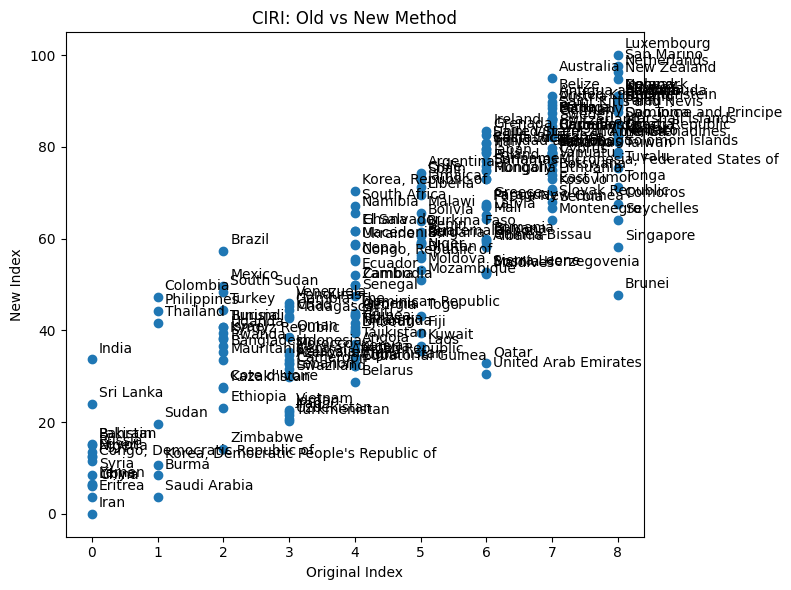

In [173]:

# Create the scatterplot
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.scatter(df_compare['PHYSINT'], df_compare['PCA_Score'])

# Label each point with the index
for i, label in enumerate(df_compare.index):
    plt.annotate(label, (df_compare['PHYSINT'][i], df_compare['PCA_Score'][i]), textcoords="offset points", xytext=(5,5), ha='left')

# Add labels and title
plt.xlabel('Original Index')
plt.ylabel('New Index')
plt.title('CIRI: Old vs New Method')
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

/var/folders/0m/d48fpfjn78d7h8p68fydssdm0000gn/T/ipykernel_42267/2230178670.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(label, (df_g20['PHYSINT'][i], df_g20['PCA_Score'][i]), textcoords="offset points", xytext=(5, 5), ha='left')


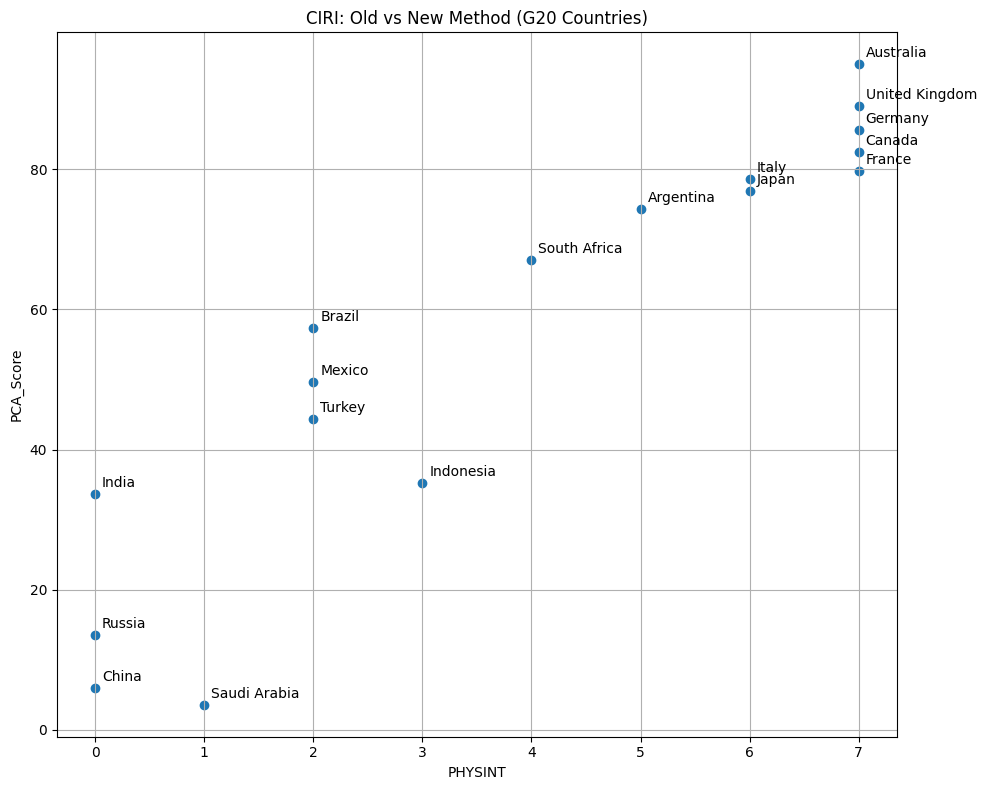

In [178]:
# List of G20 countries (based on common membership)
g20_countries = ['Argentina', 'Australia', 'Brazil', 'Canada', 'China', 'France', 'Germany', 'India', 'Indonesia',
                  'Italy', 'Japan', 'Mexico', 'Russia', 'Saudi Arabia', 'South Africa', 'South Korea',
                  'Turkey', 'United Kingdom', 'United States']

# Filter the DataFrame to include only G20 countries
df_g20 = df_compare[df_compare.index.isin(g20_countries)]
# Create the scatterplot for G20 countries
plt.figure(figsize=(10, 8))  # Adjust figure size as needed for better label visibility
plt.scatter(df_g20['PHYSINT'], df_g20['PCA_Score'])

# Label each point with the country name (index) for G20 countries
for i, label in enumerate(df_g20.index):
    plt.annotate(label, (df_g20['PHYSINT'][i], df_g20['PCA_Score'][i]), textcoords="offset points", xytext=(5, 5), ha='left')

# Add labels and title
plt.xlabel('PHYSINT')
plt.ylabel('PCA_Score')
plt.title('CIRI: Old vs New Method (G20 Countries)')
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


In [170]:
drop_ciri.columns

Index(['DISAP', 'KILL', 'POLPRIS', 'TORT', 'NEW_EMPINX', 'ASSN', 'FORMOV',
       'DOMMOV', 'SPEECH', 'ELECSD', 'NEW_RELFRE', 'WORKER', 'WECON', 'WOPOL',
       'INJUD'],
      dtype='object')

# Clustering

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np

#####
# K-Means Clustering
#####

# Perform K-Means clustering with 9 clusters and 20 random starts
#9 clusters because 0 - 8
kmeans = KMeans(n_clusters=9, n_init=20, random_state=123) 
km_out = kmeans.fit(drop_ciri)

# Get cluster assignments
cluster_assignments = km_out.labels_ + 1 # Add 1 to match R's 1-based indexing

print("\nDistribution of CIRI Index:")
print(dfciri['PHYSINT'].value_counts().sort_index())

# Display the number of observations in each cluster
print("K-Means Cluster Sizes\n(Distribution of New Index):")
print(pd.Series(cluster_assignments).value_counts().sort_index())


# Check some observations from specific clusters
print("\nSample observations from K-Means clusters:")
for cluster_num in [1, 4, 8, 3]:
    cluster_indices = np.where(cluster_assignments == cluster_num)[0]
    if len(cluster_indices) > 0:
        sample_indices = np.random.choice(cluster_indices, min(5, len(cluster_indices)), replace=False)
        print(f"Cluster {cluster_num}:")
        print(drop_ciri.index[sample_indices].tolist()) # Assuming row names are the index
    else:
        print(f"Cluster {cluster_num}: No observations in this cluster.")



Distribution of CIRI Index:
PHYSINT
0.0    14
1.0     7
2.0    16
3.0    19
4.0    29
5.0    20
6.0    29
7.0    31
8.0    29
Name: count, dtype: int64
K-Means Cluster Sizes
(Distribution of New Index):
1    17
2    18
3    24
4    15
5    22
6    17
7    21
8    34
9    26
Name: count, dtype: int64

Sample observations from K-Means clusters:
Cluster 1:
['Malta', 'Netherlands', 'Norway', 'Australia', 'Slovenia']
Cluster 4:
['Iran', 'Zimbabwe', 'Saudi Arabia', 'Vietnam', 'China']
Cluster 8:
['Botswana', 'Taiwan', 'Finland', 'Tonga', 'Cyprus']
Cluster 3:
['South Sudan', 'Macedonia', 'South Africa', 'Namibia', 'Bolivia']


In [190]:
drop_ciri.columns

Index(['DISAP', 'KILL', 'POLPRIS', 'TORT', 'NEW_EMPINX', 'ASSN', 'FORMOV',
       'DOMMOV', 'SPEECH', 'ELECSD', 'NEW_RELFRE', 'WORKER', 'WECON', 'WOPOL',
       'INJUD'],
      dtype='object')

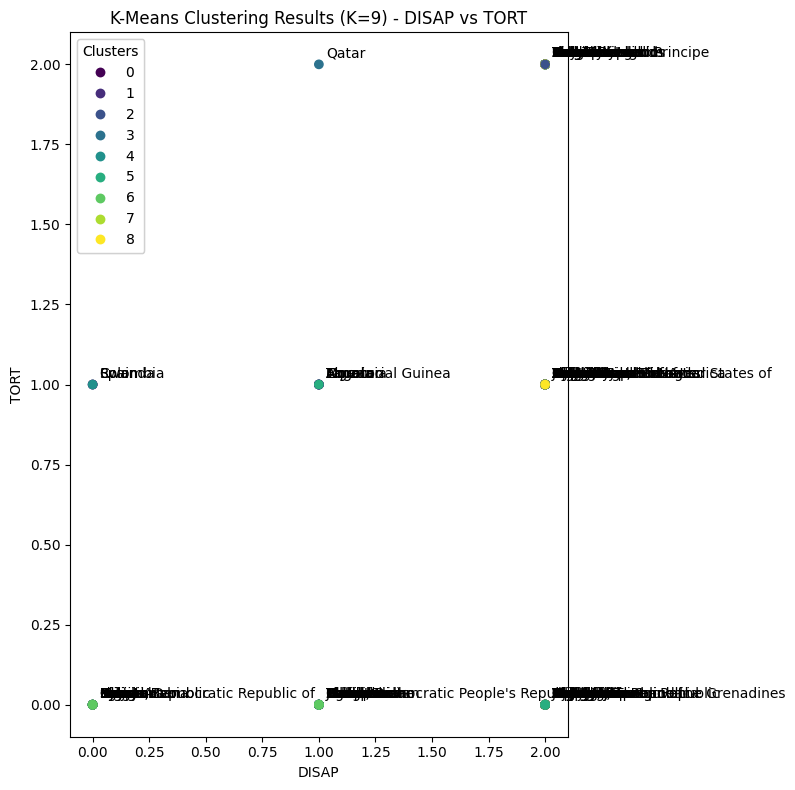

In [192]:


kmeans_ciri = KMeans(n_clusters=9,
                random_state=3,
                n_init=1).fit(drop_ciri)
kmeans_ciri
cluster_labels = kmeans_ciri.labels_
cluster_labels
# Create a DataFrame to display the states and their cluster assignments
state_names = drop_ciri.index
fig, ax = plt.subplots(figsize=(8, 8))

# Choose the two columns you want to plot on the x and y axes
x_column = 'DISAP'  # Replace with the name of the column you want for the x-axis
y_column = 'TORT'  # Replace with the name of the column you want for the y-axis

scatter = ax.scatter(drop_ciri[x_column], drop_ciri[y_column], c=cluster_labels)

# Add labels for each point (states)
for i, txt in enumerate(state_names):
    ax.annotate(txt, (drop_ciri[x_column].iloc[i], drop_ciri[y_column].iloc[i]), textcoords="offset points", xytext=(5,5), ha='left')

ax.set_xlabel(x_column)
ax.set_ylabel(y_column)
ax.set_title(f"K-Means Clustering Results (K=9) - {x_column} vs {y_column}")

# Add a legend for the clusters
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.tight_layout()
plt.show()



## Putting it all together

/var/folders/0m/d48fpfjn78d7h8p68fydssdm0000gn/T/ipykernel_42267/1939166183.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_clusters))  # You can choose a different colormap


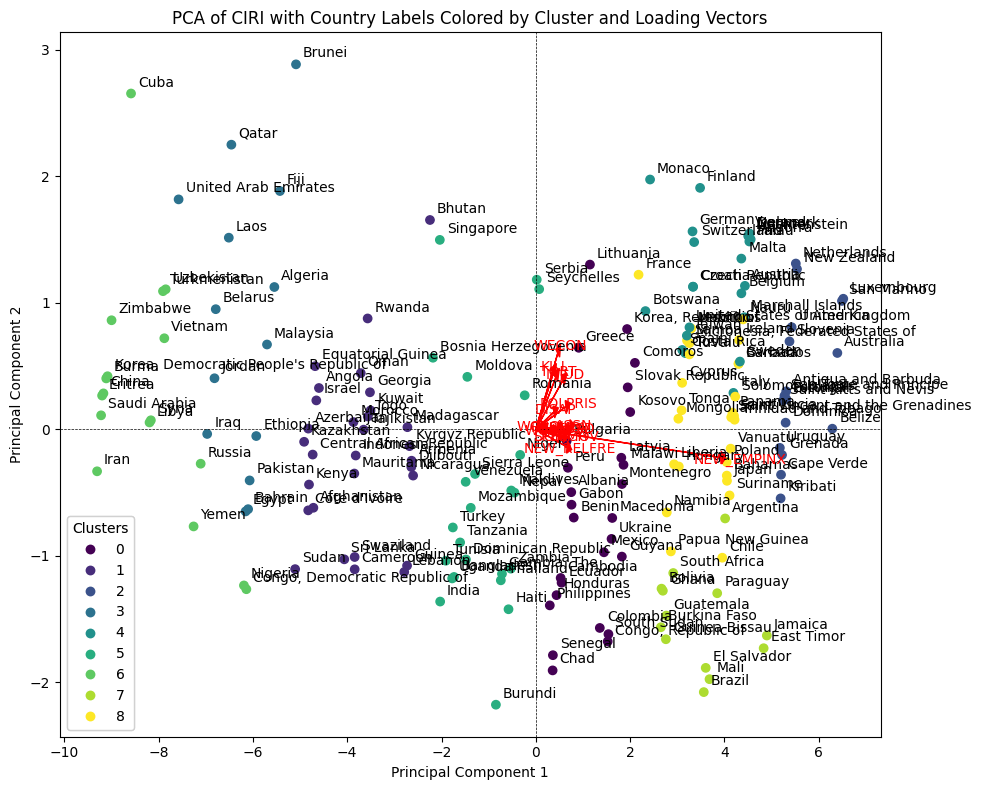

In [194]:
# Perform PCA
import matplotlib.cm as cm  # For colormaps

index_names = drop_ciri.index.tolist()
values = drop_ciri.values
feature_names = drop_ciri.columns.tolist()


pca = PCA(n_components=2)
principal_components = pca.fit_transform(values)

# Perform K-Means clustering (using the same parameters as before)
kmeans = KMeans(n_clusters=9, random_state=3, n_init=1).fit(values)
cluster_labels = kmeans.labels_

# Create a color map for the clusters
unique_clusters = np.unique(cluster_labels)
cmap = cm.get_cmap('viridis', len(unique_clusters))  # You can choose a different colormap

# Visualize

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
# Scatter plot of the first two principal components, colored by cluster
scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, cmap=cmap)

# Add labels for state names
for i, txt in enumerate(index_names):
    ax.annotate(txt, (principal_components[i, 0], principal_components[i, 1]), textcoords="offset points", xytext=(5, 5), ha='left')

# Add labels for loading vectors (principal components in original feature space)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)  # Scale loadings by sqrt of eigenvalues for better visualization
for i, feature in enumerate(feature_names):
    ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.1, head_length=0.1, linewidth=1, color='red')
    ax.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, feature, color='red', ha='center', va='center')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA of CIRI with Country Labels Colored by Cluster and Loading Vectors')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.axvline(0, color='black', linewidth=0.5, linestyle='--')

# Add a legend for the clusters
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.tight_layout()
plt.show()

/var/folders/0m/d48fpfjn78d7h8p68fydssdm0000gn/T/ipykernel_42267/242453234.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_g20 = cm.get_cmap('viridis', len(unique_clusters_g20))  # You can choose a different colormap


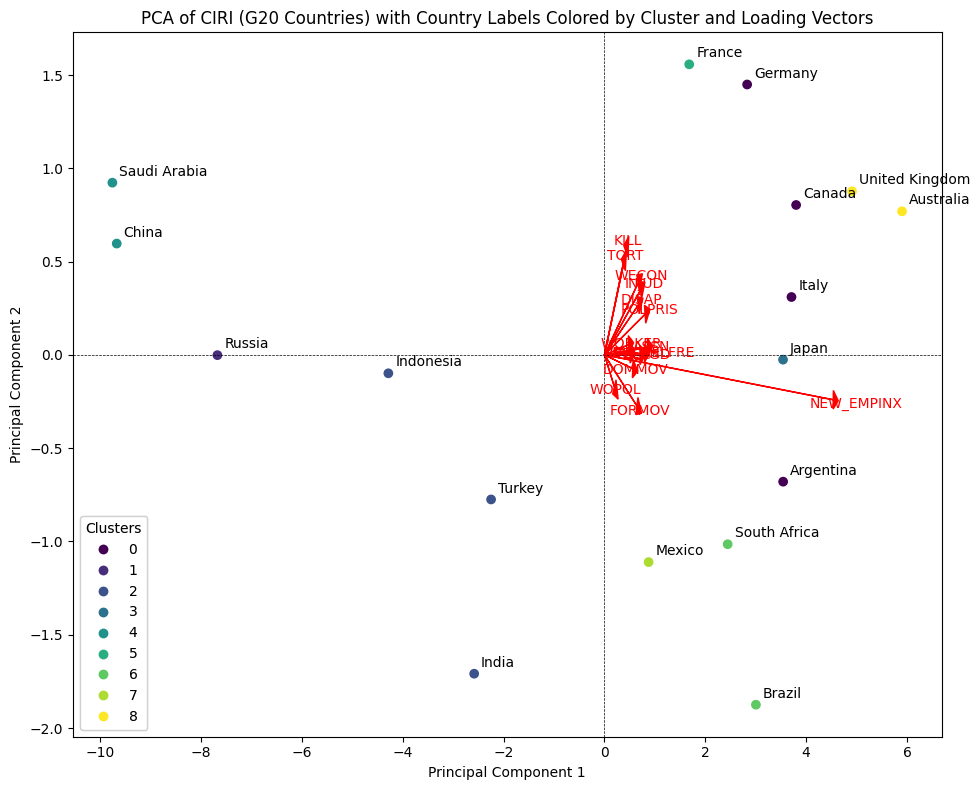

In [195]:
# Perform PCA
import matplotlib.cm as cm  # For colormaps
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming 'drop_ciri' is your DataFrame and its index contains country names

# List of G20 countries (based on common membership)
g20_countries = ['Argentina', 'Australia', 'Brazil', 'Canada', 'China', 'France', 'Germany', 'India', 'Indonesia',
                  'Italy', 'Japan', 'Mexico', 'Russia', 'Saudi Arabia', 'South Africa', 'South Korea',
                  'Turkey', 'United Kingdom', 'United States']

# Filter the DataFrame to include only G20 countries
drop_ciri_g20 = drop_ciri[drop_ciri.index.isin(g20_countries)]

index_names_g20 = drop_ciri_g20.index.tolist()
values_g20 = drop_ciri_g20.values
feature_names = drop_ciri_g20.columns.tolist()

pca_g20 = PCA(n_components=2)
principal_components_g20 = pca_g20.fit_transform(values_g20)

# Perform K-Means clustering on G20 data (using the same parameters as before)
kmeans_g20 = KMeans(n_clusters=9, random_state=3, n_init=1).fit(values_g20)
cluster_labels_g20 = kmeans_g20.labels_

# Create a color map for the clusters
unique_clusters_g20 = np.unique(cluster_labels_g20)
cmap_g20 = cm.get_cmap('viridis', len(unique_clusters_g20))  # You can choose a different colormap

# Visualize G20 data

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
# Scatter plot of the first two principal components, colored by cluster
scatter_g20 = ax.scatter(principal_components_g20[:, 0], principal_components_g20[:, 1], c=cluster_labels_g20, cmap=cmap_g20)

# Add labels for state names (G20 countries)
for i, txt in enumerate(index_names_g20):
    ax.annotate(txt, (principal_components_g20[i, 0], principal_components_g20[i, 1]), textcoords="offset points", xytext=(5, 5), ha='left')

# Add labels for loading vectors (principal components in original feature space)
loadings_g20 = pca_g20.components_.T * np.sqrt(pca_g20.explained_variance_)  # Scale loadings by sqrt of eigenvalues
for i, feature in enumerate(feature_names):
    ax.arrow(0, 0, loadings_g20[i, 0], loadings_g20[i, 1], head_width=0.1, head_length=0.1, linewidth=1, color='red')
    ax.text(loadings_g20[i, 0] * 1.1, loadings_g20[i, 1] * 1.1, feature, color='red', ha='center', va='center')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA of CIRI (G20 Countries) with Country Labels Colored by Cluster and Loading Vectors')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.axvline(0, color='black', linewidth=0.5, linestyle='--')

# Add a legend for the clusters
legend1_g20 = ax.legend(*scatter_g20.legend_elements(), title="Clusters")
ax.add_artist(legend1_g20)

plt.tight_layout()
plt.show()